In [40]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import seaborn as sns

In [56]:
sns.set_theme()

In [3]:
SEED = 42

DATA_PATH = Path().absolute().parent / "data" / "training_set.npz"

In [4]:
rng = np.random.default_rng(SEED)

In [5]:
data = np.load(DATA_PATH)
data

NpzFile '/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz' with keys: images, labels

In [6]:
images: np.ndarray = data["images"]
labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


<Axes: ylabel='Percent'>

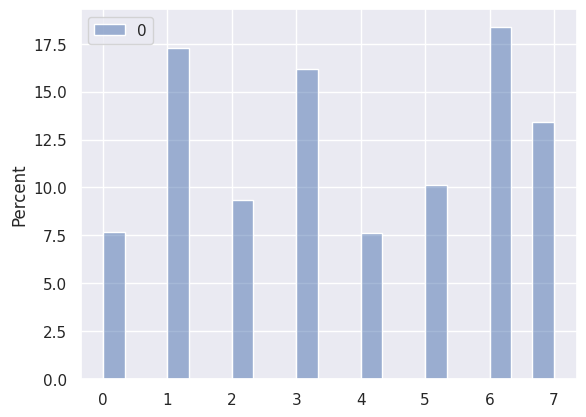

In [7]:
sns.histplot(labels, stat="percent")

In [8]:
number_labels = len(np.unique(labels))
number_labels

8

In [9]:
supports = {label: np.ravel(labels == label) for label in np.unique(labels)}
supports.keys()

dict_keys([np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7)])

In [10]:
supports[0].shape

(13759,)

In [11]:
images.shape

(13759, 96, 96, 3)

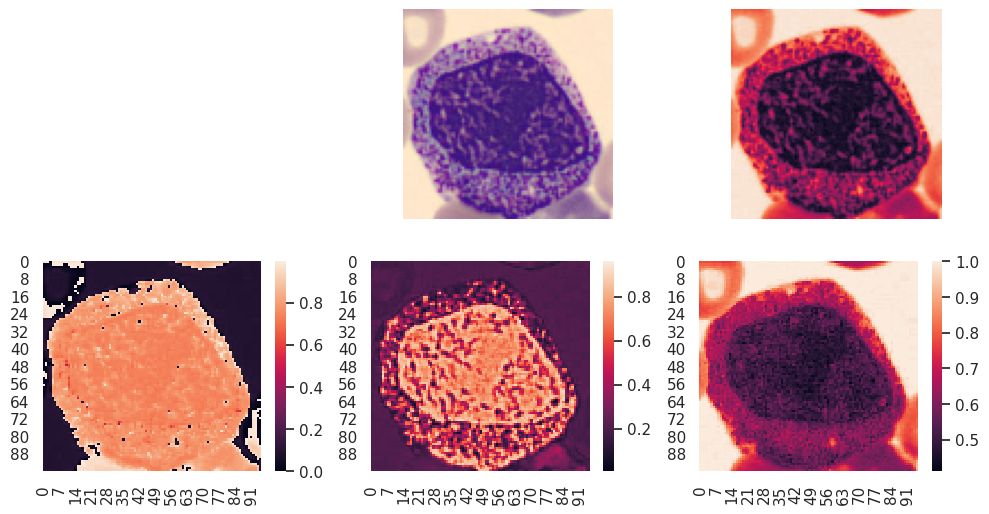

In [87]:
SELECTED_IMAGE = 48

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for ax in axes[0]:
    ax.set_axis_off()
axes[0][1].imshow(images[SELECTED_IMAGE])
axes[0][2].imshow(images[SELECTED_IMAGE].mean(axis=-1))
for i, ax in enumerate(axes[1]):
    sns.heatmap(
        rgb_to_hsv(images[SELECTED_IMAGE].astype("float") / 255)[:, :, i],
        ax=ax
    )

Plot a random sample of images from each class

We use `rng.choice` on purpose to get different images each time we run the cell so we can see more pictures by executing multiple times.

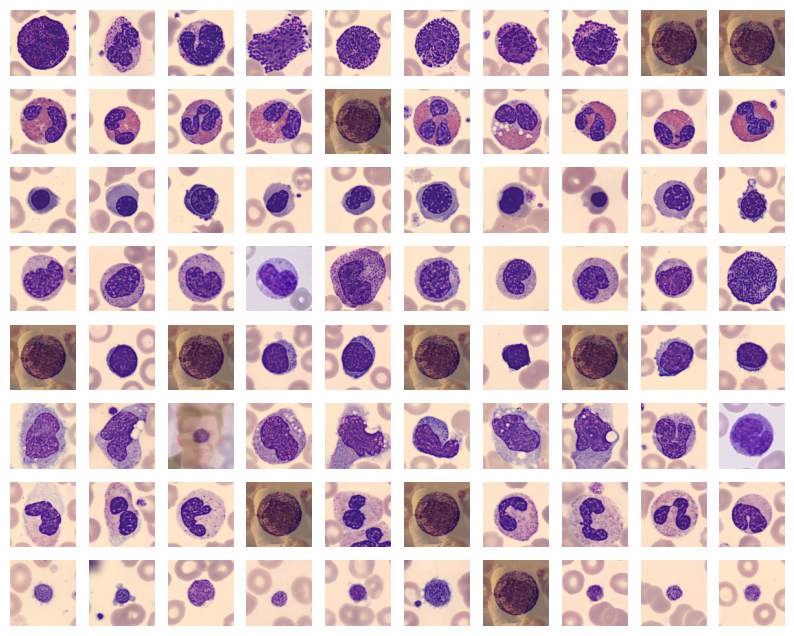

In [37]:
fig, axes = plt.subplots(nrows=number_labels, ncols=10, figsize=(10, 8))
for row_axes, support in zip(axes, supports.values()):
    indices = rng.choice(support.nonzero()[0], size=10, replace=False)
    for ax, i in zip(row_axes, indices):
        ax.set_axis_off()
        ax.imshow(images[i])

Analyse image intensity distributions

<Axes: >

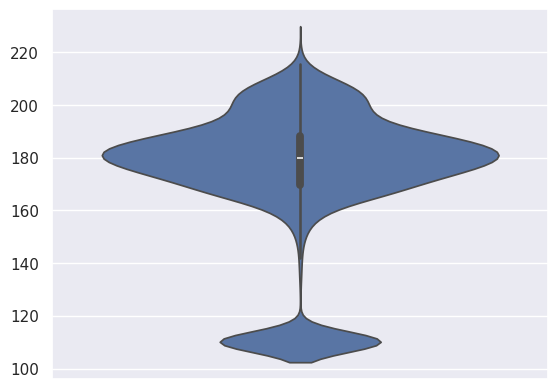

In [13]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))
sns.violinplot(image_means)

### Check for duplicates

<Axes: ylabel='Count'>

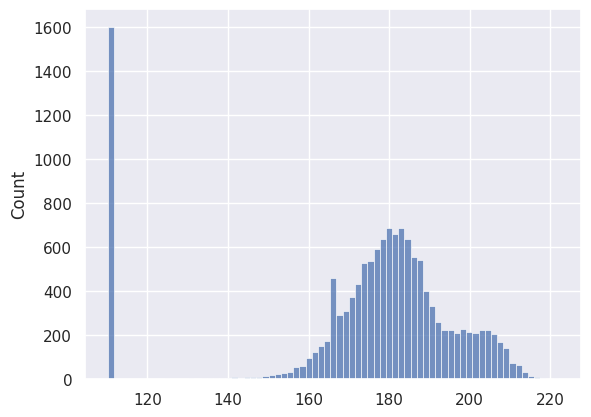

In [14]:
sns.histplot(image_means)

In [15]:
TOLERANCE = 0
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [16]:
for indices in mean_indices.values():
    print(np.unique(labels[indices]))

[0 1 2 3 4 5 6 7]
[5]


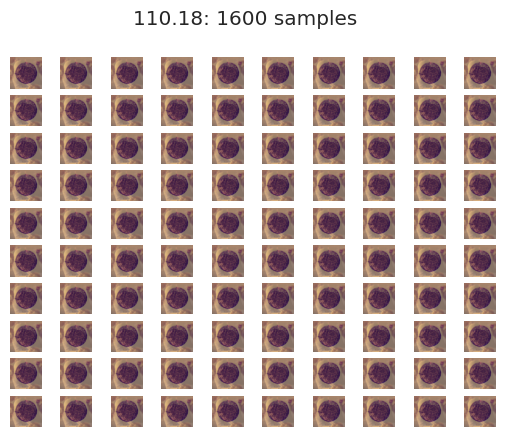

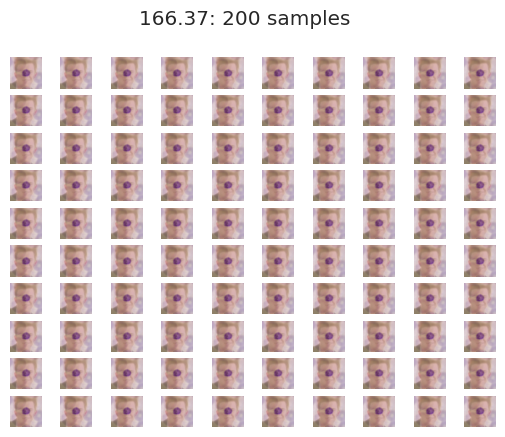

In [36]:
for mean, indices in mean_indices.items():
    # Limit to first 100 samples
    selected_indices = rng.choice(indices, 100, replace=False)
    fig, axes = plt.subplots(ncols=10, nrows=10)
    fig.suptitle(f"{mean:.2f}: {len(indices)} samples")
    axes = axes.reshape((-1))
    for ax in axes:
        ax.set_axis_off()
    for i, ax in zip(selected_indices, axes):
        ax.imshow(images[i])

In [18]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [19]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

### Check for statistical outliers in the images

In [20]:
dedup_image_means = image_means[original_indices]
dedup_image_means

array([205.04958767, 160.25502749, 191.14883536, ..., 182.57175926,
       175.91677517, 187.80852141])

In [21]:
image_means_quantiles = np.quantile(dedup_image_means, (0.25, 0.5, 0.75))
image_means_quantiles

array([174.52953197, 181.89959491, 190.10268374])

In [22]:
outlier_factor: np.ndarray = np.abs(dedup_image_means - image_means_quantiles[1])
outlier: np.ndarray = outlier_factor > 1.5 * (
    image_means_quantiles[2] - image_means_quantiles[0]
)
outlier.sum()

np.int64(950)

In [23]:
outlier.nonzero()[0].shape

(950,)

In [24]:
outlier_indices = outlier.nonzero()[0]
outlier_indices

array([   17,    47,    48,    55,    66,    69,    85,    88,    90,
         104,   105,   106,   125,   132,   133,   138,   145,   151,
         161,   162,   163,   177,   195,   199,   202,   205,   244,
         245,   257,   269,   270,   271,   286,   290,   305,   310,
         319,   330,   335,   352,   369,   377,   378,   391,   402,
         409,   413,   431,   432,   442,   443,   455,   491,   499,
         502,   507,   522,   523,   526,   561,   575,   577,   601,
         617,   646,   693,   705,   711,   725,   734,   738,   755,
         764,   765,   770,   800,   806,   834,   841,   842,   851,
         860,   881,   885,   886,   911,   947,   961,   966,   985,
        1002,  1004,  1029,  1030,  1059,  1063,  1089,  1092,  1094,
        1095,  1111,  1124,  1132,  1151,  1152,  1153,  1154,  1168,
        1183,  1192,  1203,  1221,  1225,  1228,  1241,  1242,  1246,
        1259,  1262,  1263,  1286,  1294,  1298,  1306,  1327,  1330,
        1331,  1347,

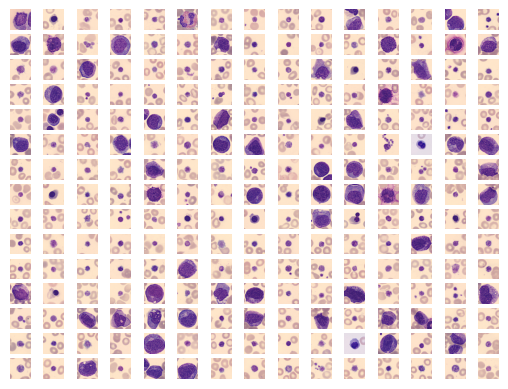

In [30]:
fig, axes = plt.subplots(nrows=15, ncols=15)
axes = axes.reshape((-1))
for ax in axes:
    ax.set_axis_off()
for i, ax in zip(rng.permutation(outlier_indices), axes):
    ax.imshow(images[i])